## City of Chicago business licence data for licenses with start dates between January 1, 2015 and December 31st, 2018

In [135]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('chicago_business_licenses_2015_through_2018.csv', dtype=str)

In [4]:
# Clean up column names
df.columns = df.columns.str.replace(' ','_').str.lower().str.replace("'", "")

In [122]:
df.head()

,id,license_id,account_number,site_number,legal_name,doing_business_as_name,address,city,state,zip_code,ward,precinct,ward_precinct,police_district,license_code,license_description,business_activity_id,business_activity,license_number,application_type,application_created_date,application_requirements_complete,payment_date,conditional_approval,license_term_start_date,license_term_expiration_date,license_approved_for_issuance,date_issued,license_status,license_status_change_date,ssa,latitude,longitude,location
0,1620668-20160516,2455262,295026,1,BUCCI BIG & TALL INC.,BUCCI BIG & TALL INC.,558 W ROOSEVELT RD,CHICAGO,IL,60607,25,28,25-28,1,1010,Limited Business License,911,Retail Sales of Clothing / Accessories / Shoes,1620668,RENEW,NaN,03/15/2016,05/18/2016,N,05/16/2016,05/15/2018,05/18/2016,08/30/2016,AAI,NaN,NaN,41.867338566,-87.641590057,"(41.86733856638269, -87.64159005699716)"
1,2368602-20160616,2460909,291461,3,"PROJECT: VISION , INC.","PROJECT : VISION , INC",2301 S ARCHER AVE 1 1,CHICAGO,IL,60616,25,18,25-18,9,1625,Raffles,720,Not-For-Profit Selling Raffles for Prizes of $50 or More,2368602,RENEW,NaN,04/15/2016,06/21/2016,N,06/16/2016,06/15/2017,06/21/2016,06/22/2016,AAC,08/30/2016,NaN,41.850842944,-87.638734244,"(41.85084294374687, -87.63873424399071)"
2,2488345-20160830,2488345,409564,1,"BURKS HEATING AND COOLING SOLUTIONS, LLC","BURKS HEATING AND COOLING SOLUTIONS, LLC",5722 S WOOD ST 1ST,CHICAGO,IL,60636,15,35,15-35,7,4404,Regulated Business License,674,Home Repair Services (Home Occ),2488345,ISSUE,08/30/2016,08/30/2016,08/30/2016,N,08/30/2016,09/15/2018,08/30/2016,08/30/2016,AAI,NaN,NaN,41.78961679,-87.669471996,"(41.78961679000226, -87.66947199630827)"
3,2354707-20160916,2482568,393149,1,ANGELINE R. MC CARTHY,ANGELINE R. MC CARTHY,17707 S HARLEM ST 1,TINLEY PARK,IL,60477,NaN,NaN,NaN,NaN,4406,Peddler License,915,"Street Performer, Moving Along the Public Way (Special)",2354707,RENEW,NaN,07/15/2016,08/30/2016,N,09/16/2016,09/15/2018,NaN,08/30/2016,AAI,NaN,NaN,NaN,NaN,NaN
4,2488245-20160830,2488245,336275,2,MARIA G CAHUE,BEAUTY AND HEALTH,2705 W 51ST ST 1ST,CHICAGO,IL,60632,14,19,14-19,9,1010,Limited Business License,904,Retail Sales of General Merchandise,2488245,ISSUE,08/29/2016,08/30/2016,08/30/2016,N,08/30/2016,06/15/2017,08/30/2016,08/30/2016,AAI,NaN,NaN,41.80091646,-87.691799519,"(41.80091646021564, -87.69179951881104)"


### Location
Nearly 12K records (8.4%) are linked to locations outside of Chicago. These are largely entities such as construction companies that are licenced to do work in Chicago, but have no physical location in the city. 

This project focuses on businesses considering a physical location in Chiacgo, so these non-Chicago records will be excluded from the dataset.


In [123]:
print('Number of locations outside of Chiacgo:', len(df.id.loc[df.city != 'CHICAGO']),
     '\nPercent of locations outside of Chicago: ', (round(len(df.id.loc[df.city != 'CHICAGO'])/len(df.index),4))*100,'%')

Number of locations outside of Chiacgo: 11780 
Percent of locations outside of Chicago:  8.44 %


In [132]:
chicago_only_df = df.loc[df.city == 'CHICAGO']
len(chicago_only_df)

127860

## Null Values

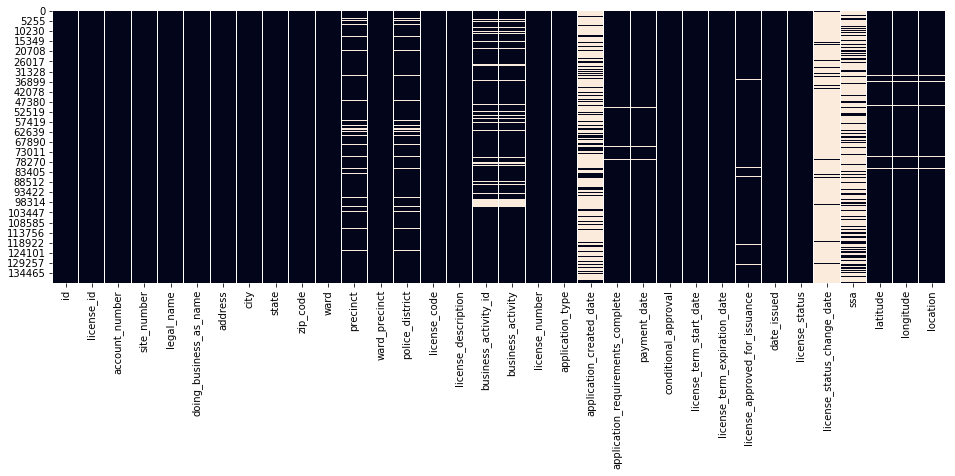

In [8]:
# View null values
plt.figure(figsize = (16,5))
sns.heatmap(chicago_only_df.isnull(), cbar=False)

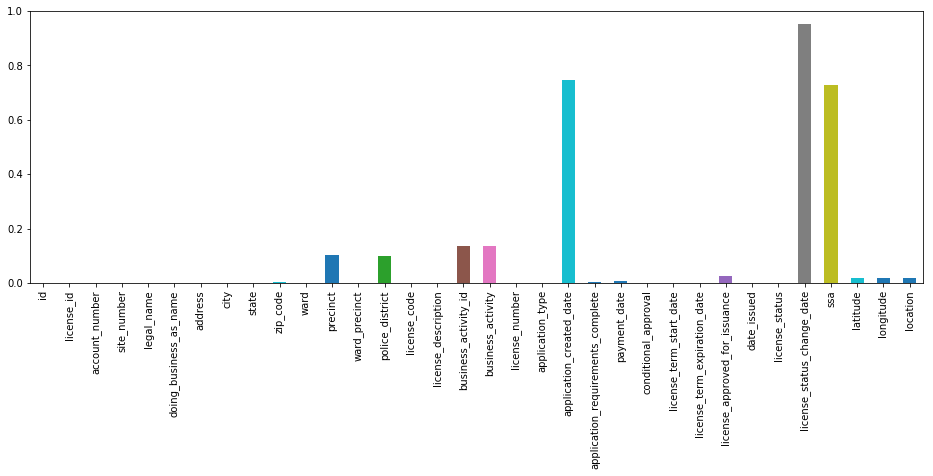

In [9]:
plt.figure(figsize = (16,5))

# get percent of values that are null, excluding fields with no null values
(1 - chicago_only_df.count()/len(chicago_only_df.index)).where(chicago_only_df.count() < len(df.index)).dropna().plot(kind='bar')

### Missing Location Data

Location is an ingegral part of this project, but 2% of records do not have latitude and longitude data. However, all locations have a street address. Although many of these have non-standard address formats (e.g. 17 W ADAMS ST BSMT & 1ST), it it will be possible to geocode some addresses without lat/long data using the Census Bureau's geocoder (https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form). Addresses that cannot be sucessfully geocoded will be discarded.


In [124]:
print('Number of recordss missing a location: ',len(chicago_only_df.index) - chicago_only_df['latitude'].count())
print('Percent of recordss missing a location: ',round(1 - chicago_only_df['location'].count()/len(chicago_only_df.index), 3) * 100)

Number of recordss missing a location:  2468
Percent of recordss missing a location:  1.9


### Business activity
A record's 'business activity' is the description of what a businesses does. See below for examples of the difference between the broader 'license_description' and 'business_activity'

In [136]:
chicago_only_df[['license_description','business_activity']].head()

,license_description,business_activity
0,Limited Business License,Retail Sales of Clothing / Accessories / Shoes
1,Raffles,Not-For-Profit Selling Raffles for Prizes of $50 or More
2,Regulated Business License,Home Repair Services (Home Occ)
4,Limited Business License,Retail Sales of General Merchandise
5,Retail Food Establishment,Sale of Food Prepared Onsite Without Dining Area


A single license can have multiple associated business activities, seperated by a pipe. I will likely create one row per business activity. For example:


In [189]:
#[['license_description','business_activity']]
#df[df['id'].str.contains('|')]

In [187]:
# Debug
#chicago_only_df['business_activity'].filter(like='|', axis=0) 
#chicago_only_df[chicago_only_df['business_activity'].str.contains("so")]#.drop_duplicates()
chicago_only_df['business_activity'].drop_duplicates()

0         Retail Sales of Clothing / Accessories / Shoes                                                                                                                                                                                                 
1         Not-For-Profit Selling Raffles for Prizes of $50 or More                                                                                                                                                                                       
2         Home Repair Services (Home Occ)                                                                                                                                                                                                                
4         Retail Sales of General Merchandise                                                                                                                                                                                                            


### Missing business activity
Nearly 14% of records are missing a business activity. 

In [126]:
print('Number of recordss missing a business activity: ', chicago_only_df.business_activity.isna().sum())
print('Percent of recordss missing a business activity: ', round(1 - chicago_only_df.business_activity.count()/len(chicago_only_df.index), 4) * 100)

Number of recordss missing a business activity:  17525
Percent of recordss missing a business activity:  13.71


Nearly all businesses with no business activity listed have "Limited Business License" license types:

In [67]:
null_business_activity_df = chicago_only_df.loc[df.business_activity.isna()].copy()
null_business_activity_df.groupby(['license_description'])['license_description'].count().sort_values(ascending = False)

license_description
Limited Business License                         17498
Manufacturing Establishments                         7
Animal Care License                                  7
Industrial Private Event Venue                       4
Regulated Business License                           2
Music and Dance                                      2
Children's Services Facility License                 2
Retail Food Establishment                            1
Consumption on Premises - Incidental Activity        1
Commercial Garage                                    1
Name: license_description, dtype: int64

In [127]:
# List of businesses missing business activities.
    # Another option is to view businesses by owner names: 
    # null_business_activity_df.groupby(['legal_name'])['legal_name'].count().sort_values(ascending = False)
dbas_with_null_bus_act = null_business_activity_df.groupby(['doing_business_as_name'])['doing_business_as_name'].count().sort_values(ascending = False)

In [128]:
# Convert to dataframe
dbas_with_null_bus_act = dbas_with_null_bus_act.to_frame(name='count_of_records')


The majority of businesses without business activity types have fewer than 10 records. 38 businesses have more than 10 records. I think it's a reasonable use of time to manually assign business types to these 38 businesses. Depending on time constraints, I may manually code businesses with as few as 5 records. There are 99 such businesses.


In [89]:
dbas_with_null_bus_act.loc[dbas_with_null_bus_act.count_of_records >= 10].count()

count_of_records    38
dtype: int64

In [129]:
dbas_with_null_bus_act.loc[dbas_with_null_bus_act.count_of_records >= 10]

,count_of_records
doing_business_as_name,
"FEDEX OFFICE AND PRINT SVCS, INC.",58
T-MOBILE,48
PUBLIC STORAGE,40
ENTERPRISE RENT-A-CAR,37
HUDSON NEWS,31
Innovative FOTO,29
PSAV Presentation Services,24
"TELEPORT COMMUNICATIONS AMERICA, LLC",24
THE UPS STORE,22


### Temporary Licenses
Temporary or pop-up businesses licenses are issued for events such as street fairs or non-profit raffles. They are not permanent businesses, but may have an impact on business success. As such, the number and types of these licenses issued will be a feature of my final dataset. 

In [121]:
# Number of pop-up license records.
chicago_only_df.id.loc[(chicago_only_df['license_description'] == 'Pop-Up Retail User') | 
                    (chicago_only_df['license_description'] == 'Pop-Up Food Est. User - Tier II')].count()

810

In [110]:
pd.set_option('display.max_colwidth', -1)
chicago_only_df[['license_description', 'business_activity']].\
loc[(df['license_description'] == 'Pop-Up Retail User') | \
    (df['license_description'] == 'Pop-Up Food Est. User - Tier II')].drop_duplicates()

,license_description,business_activity
91324,Pop-Up Retail User,"Organizer of Vendors That Sell for Retail at a Trade Show, Exhibition or Convention"
91327,Pop-Up Retail User,"Sale of General Merchandise, Seasonal Items"
92431,Pop-Up Retail User,"181-365 Day Pop-Up Retail User, Sale of General Merchandise/Seasonal Items"
92530,Pop-Up Retail User,"1-90 Day Pop-Up Retail User, Sale of General Merchandise/Seasonal Items"
92868,Pop-Up Food Est. User - Tier II,"90 Day Pop-Up Food Est. User - Tier II (Sale of Pre-Packaged, Prepared Hot/Cold Food, Final Prep On-Site)"
92905,Pop-Up Retail User,"Organizer of a 1-5 Day Event w/ Pop-Up Retail Users at a Trade Show, Exhibition or Convention"
93079,Pop-Up Retail User,"1-5 Day Pop-Up Retail User, Sale of General Merchandise/Seasonal Items"


In [ ]:
# todo
    #  Exclude airport locations
    # get list of distinct business activities